In [1]:
%load_ext autoreload
%autoreload 2
%cd ..

import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import re

from util import *

# Set the style for visualizations
plt.style.use('ggplot')
sns.set_palette("Set2")

/Users/waileongleong/python/loan-analysis


In [2]:
from catboost import CatBoostClassifier

In [61]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt

def train_catboost_classifier(
    data, 
    numerical_cols=None,
    log_transform_cols=None, 
    categorical_cols=None, 
    target_col=None,
    test_size=0.2,
    random_state=42,
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    early_stopping_rounds=50,
    verbose=100,
    use_sklearn_preprocessing=True,
    # New parameters for handling high cardinality categorical features
    simple_ctr=None,
    combinations_ctr=None,
    max_ctr_complexity=4,
    ctr_target_border_count=1,
    counter_calc_method='SkipTest',
    per_feature_ctr_description=None
):
    """
    Train a CatBoost classifier with data transformation on the provided data.
    CatBoost will handle categorical features natively.
    
    Parameters:
    -----------
    data : pandas.DataFrame
        The input dataframe containing features and target
    numerical_cols : list
        List of numerical column names to use standard median imputation
    log_transform_cols : list
        List of numerical column names to apply power transformation after imputation
    categorical_cols : list
        List of categorical column names to use as features
    target_col : str
        Name of the target column
    test_size : float, default=0.2
        Proportion of data to use for testing
    random_state : int, default=42
        Random seed for reproducibility
    iterations : int, default=1000
        Maximum number of trees to build
    learning_rate : float, default=0.1
        Learning rate for gradient boosting
    depth : int, default=6
        Depth of the trees
    early_stopping_rounds : int, default=50
        Number of rounds to wait for improvement before early stopping
    verbose : int, default=100
        Print evaluation metrics every 'verbose' iterations
    use_sklearn_preprocessing : bool, default=True
        Whether to use sklearn preprocessing for numerical features only
    simple_ctr : list, default=None
        List of simple counters for categorical features
        Example: ['Borders', 'BinarizedTargetMeanValue', 'Counter']
    combinations_ctr : list, default=None
        List of combinations counters for categorical features
        Example: ['Borders', 'Counter']
    max_ctr_complexity : int, default=4
        Maximum number of categorical features to combine for combinations CTR
    ctr_target_border_count : int, default=1
        Number of borders to use for target binarization
    counter_calc_method : str, default='SkipTest'
        Method to calculate counters: 'SkipTest', 'Full'
    per_feature_ctr_description : list, default=None
        Per feature CTR description
        
    Returns:
    --------
    tuple: (trained_model, X_train, X_test, y_train, y_test)
        Returns the trained model and the train/test data splits
    """
    
    if not numerical_cols and not log_transform_cols and not categorical_cols:
        raise ValueError("At least one column type must be provided")
    
    if not target_col:
        raise ValueError("target_col must be provided")
    
    # Prepare feature columns list
    feature_cols = []
    if numerical_cols:
        feature_cols.extend(numerical_cols)
    if log_transform_cols:
        feature_cols.extend(log_transform_cols)
    if categorical_cols:
        feature_cols.extend(categorical_cols)
    
    print(f"Training CatBoost model with {len(feature_cols)} features")
    print(feature_cols)
    
    # Prepare the data
    X = data[feature_cols]
    y = data[target_col]
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    
    # Set default CTR parameters for high cardinality features if not provided
    if simple_ctr is None:
        simple_ctr = ['Borders', 'Counter']
    
    if combinations_ctr is None:
        combinations_ctr = ['Borders', 'Counter']
    
    # Initialize the CatBoost model with high cardinality handling
    catboost_model = CatBoostClassifier(
        iterations=iterations,
        learning_rate=learning_rate,
        depth=depth,
        random_seed=random_state,
        verbose=verbose,
        early_stopping_rounds=early_stopping_rounds,
        auto_class_weights='Balanced',
        # CTR settings for high cardinality features
        simple_ctr=simple_ctr,
        combinations_ctr=combinations_ctr,
        max_ctr_complexity=max_ctr_complexity,
        ctr_target_border_count=ctr_target_border_count,
        counter_calc_method=counter_calc_method,
        # per_feature_ctr_description=per_feature_ctr_description
    )
    
    if use_sklearn_preprocessing and (numerical_cols or log_transform_cols or categorical_cols):
        # Create preprocessing pipelines
        num_imputer = SimpleImputer(strategy='median')
        power_transformer = PowerTransformer()
        
        # Define transformers for different column types
        num_transformer = make_pipeline(num_imputer)
        pow_transformer = make_pipeline(num_imputer, power_transformer)
        cat_null_transformer = make_pipeline(SimpleImputer(strategy='constant', fill_value='Unknown'))
        
        # Create column transformer
        transformers = []
        if numerical_cols:
            transformers.append(('num', num_transformer, numerical_cols))
        if log_transform_cols:
            transformers.append(('power', pow_transformer, log_transform_cols))
        if categorical_cols:
            transformers.append(('cat', cat_null_transformer, categorical_cols))
            
        preprocessor = ColumnTransformer(
            transformers=transformers,
            # Remove remainder='passthrough' as we're explicitly handling all columns
        )
        
        # Transform the training data
        X_train_transformed = preprocessor.fit_transform(X_train)
        X_test_transformed = preprocessor.transform(X_test)
        
        # Keep track of column order and types after transformation
        all_features = []
        if numerical_cols:
            all_features.extend(numerical_cols)
        if log_transform_cols:
            all_features.extend(log_transform_cols)
        if categorical_cols:
            all_features.extend(categorical_cols)
            
        # Calculate categorical column indices in the transformed data
        cat_indices = []
        current_idx = 0
        
        if numerical_cols:
            current_idx += len(numerical_cols)
        if log_transform_cols:
            current_idx += len(log_transform_cols)
        if categorical_cols:
            cat_indices = list(range(current_idx, current_idx + len(categorical_cols)))
        
        # Rebuild dataframes with proper column names
        X_train_transformed_df = pd.DataFrame(
            X_train_transformed,
            index=X_train.index,
            columns=all_features
        )
        
        X_test_transformed_df = pd.DataFrame(
            X_test_transformed, 
            index=X_test.index,
            columns=all_features
        )
        
        # Create Pool objects with categorical features
        train_pool = Pool(
            data=X_train_transformed_df,
            label=y_train,
            cat_features=categorical_cols if categorical_cols else None
        )
        
        test_pool = Pool(
            data=X_test_transformed_df,
            label=y_test,
            cat_features=categorical_cols if categorical_cols else None
        )
        
        # Train the model with preprocessed data
        catboost_model.fit(
            train_pool,
            eval_set=test_pool,
            plot=True
        )
        
        # Store the preprocessor for future use
        catboost_model.preprocessor = preprocessor
        
    else:
        # Let CatBoost handle all features directly
        train_pool = Pool(
            data=X_train,
            label=y_train,
            cat_features=categorical_cols if categorical_cols else None
        )
        
        test_pool = Pool(
            data=X_test,
            label=y_test,
            cat_features=categorical_cols if categorical_cols else None
        )
        
        # Train the model
        catboost_model.fit(
            train_pool,
            eval_set=test_pool,
            plot=True
        )
    
    # Make predictions
    if use_sklearn_preprocessing and (numerical_cols or log_transform_cols):
        y_pred = catboost_model.predict(X_test_transformed_df)
    else:
        y_pred = catboost_model.predict(X_test)
    
    # Print evaluation metrics
    print("Model Evaluation:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    
    # Feature importance
    feature_importance = catboost_model.get_feature_importance()
    feature_names = feature_cols
    sorted_idx = np.argsort(feature_importance)
    plt.figure(figsize=(10, 12))
    plt.barh(
        np.array(feature_names)[sorted_idx], 
        feature_importance[sorted_idx]
    )
    plt.xlabel("Feature Importance")
    plt.title("CatBoost Feature Importance")
    plt.tight_layout()
    plt.show()
    
    return catboost_model, X_train, X_test, y_train, y_test

# Helper function to plot ROC curve
def plot_roc_curve(model, X_test, y_test):
    from sklearn.metrics import roc_curve, auc
    
    # Check if we need to preprocess the data
    if hasattr(model, 'preprocessor'):
        X_test_proc = model.preprocessor.transform(X_test)
        X_test_proc = pd.DataFrame(X_test_proc, columns=X_test.columns)
        y_score = model.predict_proba(X_test_proc)[:, 1]
    else:
        y_score = model.predict_proba(X_test)[:, 1]
        
    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

,loan_amnt,int_rate,dti,grade,annual_inc,home_ownership,pymnt_plan,purpose,emp_title,loan_status,emp_length,issue_date,term_months,emp_length_years,is_default,dti_capped
i64,f64,f64,f64,str,f64,str,str,str,str,str,str,datetime[μs],str,i8,i32,f64
0,5000.0,10.65,27.65,"""B""",24000.0,"""RENT""","""n""","""credit_card""","""Unknown""","""Fully Paid""","""10+ years""",2011-12-01 00:00:00,"""36""",10,0,27.65
1,2500.0,15.27,1.0,"""C""",30000.0,"""RENT""","""n""","""car""","""Ryder""","""Charged Off""","""< 1 year""",2011-12-01 00:00:00,"""60""",0,1,1.0
2,2400.0,2.2,8.72,"""C""",12252.0,"""RENT""","""n""","""small_business""","""Unknown""","""Fully Paid""","""10+ years""",2011-12-01 00:00:00,"""36""",10,0,8.72
3,10000.0,13.49,20.0,"""C""",49200.0,"""RENT""","""n""","""other""","""AIR RESOURCES BOARD""","""Fully Paid""","""10+ years""",2011-12-01 00:00:00,"""36""",10,0,20.0
5,5000.0,7.9,11.2,"""A""",36000.0,"""RENT""","""n""","""wedding""","""Veolia Transportaton""","""Fully Paid""","""3 years""",2011-12-01 00:00:00,"""36""",3,0,11.2
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
887351,4200.0,15.99,36.93,"""D""",48000.0,"""MORTGAGE""","""n""","""medical""","""supervisor""","""Charged Off""","""10+ years""",2015-01-01 00:00:00,"""36""",10,1,36.93
887364,10775.0,25.4,13.22,"""A""",54000.0,"""RENT""","""n""","""debt_consolidation""","""Coordinator of RSVP""","""Fully Paid""","""< 1 year""",2015-01-01 00:00:00,"""36""",0,0,13.22
887366,6225.0,16.49,18.58,"""D""",27000.0,"""RENT""","""n""","""debt_consolidation""","""Painter""","""Fully Paid""","""2 years""",2015-01-01 00:00:00,"""36""",2,0,18.58


Loading and preprocessing data...
Dataset shape: (887379, 14)

Column names and data types:
Schema({'': Int64, 'loan_amnt': Float64, 'term': String, 'int_rate': Float64, 'dti': Float64, 'grade': String, 'annual_inc': Float64, 'home_ownership': String, 'pymnt_plan': String, 'purpose': String, 'emp_title': String, 'issue_d': String, 'loan_status': String, 'emp_length': String})
Outlier boundaries for dti:
  Lower bound: -23.07
  Upper bound: 55.82000000000001
  Number of outliers: 330 (0.13%)
Dataset shape after filtering: (248463, 17)
Training CatBoost model with 7 features
['annual_inc', 'loan_amnt', 'dti', 'term_months', 'home_ownership', 'purpose', 'emp_title']


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6898072	test: 0.6898800	best: 0.6898800 (0)	total: 71.2ms	remaining: 35.5s
100:	learn: 0.6469227	test: 0.6469417	best: 0.6469417 (100)	total: 5.67s	remaining: 22.4s
200:	learn: 0.6447757	test: 0.6453477	best: 0.6453477 (200)	total: 11.1s	remaining: 16.5s
300:	learn: 0.6425044	test: 0.6445002	best: 0.6444944 (299)	total: 16.1s	remaining: 10.6s
400:	learn: 0.6403467	test: 0.6440103	best: 0.6439834 (390)	total: 21.5s	remaining: 5.31s
499:	learn: 0.6384793	test: 0.6439757	best: 0.6439229 (476)	total: 26.9s	remaining: 0us

bestTest = 0.6439228626
bestIteration = 476

Shrink model to first 477 iterations.
Model Evaluation:
Accuracy: 0.6384

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.64      0.74     40618
           1       0.28      0.61      0.38      9075

    accuracy                           0.64     49693
   macro avg       0.58      0.63      0.56     49693
weighted avg       0.77      0.64      0.68     49

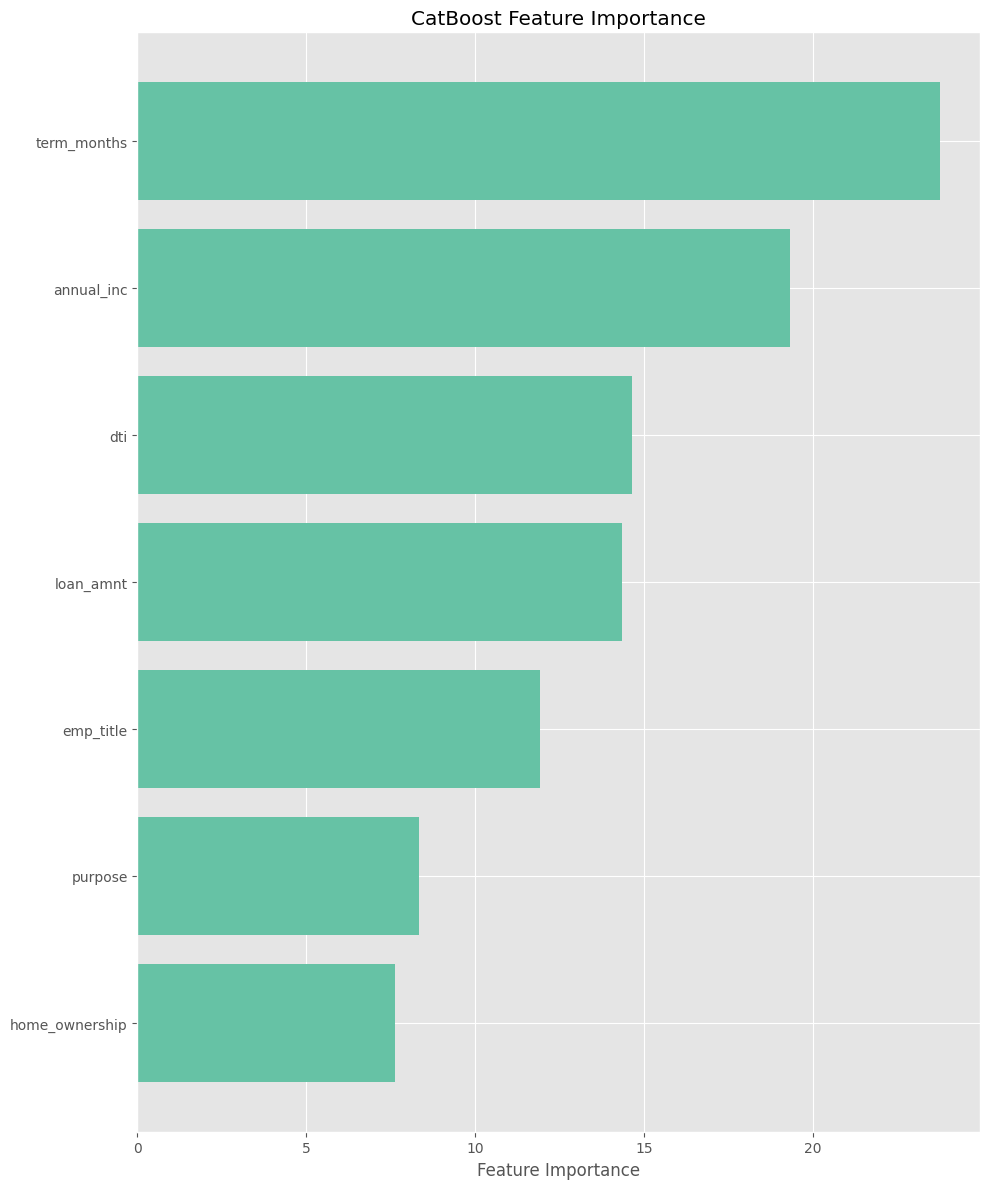

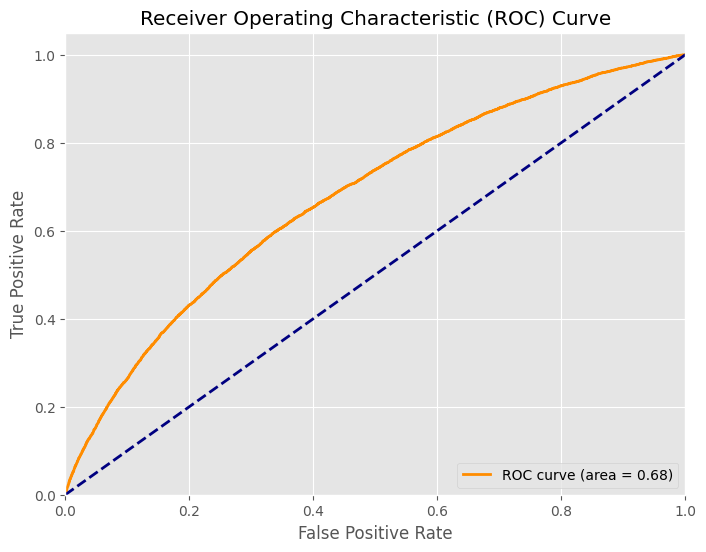

In [77]:

df_raw = load_and_preprocess_data("./data/loans_fs.csv")

# Define your columns
numerical_cols = [] 
log_transform_cols = ['annual_inc', 'loan_amnt','dti']  # columns that need power transformation
categorical_cols = ['term_months','home_ownership','purpose','emp_title']
target_col = 'is_default'
df_raw = df_raw.with_columns(pl.col("term_months").cast(pl.Utf8).alias("term_months"))
df_raw = df_raw.with_columns(pl.col('emp_title').fill_null('Unknown').alias('emp_title'))
df = df_raw.select(*(log_transform_cols + categorical_cols + [target_col])).to_pandas()
# Train the model with sklearn preprocessing
pipeline, X_train, X_test, y_train, y_test = train_catboost_classifier(
    data=df,
    numerical_cols=numerical_cols,
    log_transform_cols=log_transform_cols,
    categorical_cols=categorical_cols,
    target_col=target_col,
    iterations=500,
    learning_rate=0.05,
    use_sklearn_preprocessing=True,
        simple_ctr=['Borders', 'BinarizedTargetMeanValue', 'Counter'],
    combinations_ctr=['Borders', 'Counter'],
    max_ctr_complexity=4,
    counter_calc_method='SkipTest',
)

# Plot ROC curve
plot_roc_curve(pipeline, X_test, y_test)

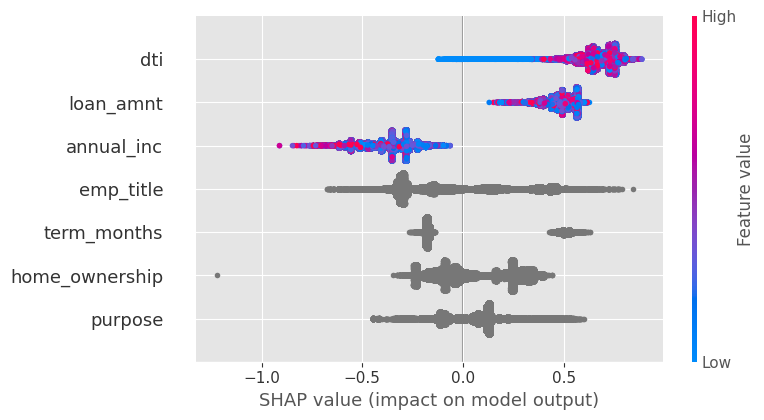

In [87]:
import shap
explainer = shap.TreeExplainer(pipeline)
shap_values = explainer(X_train)
shap.summary_plot(shap_values, X_train)

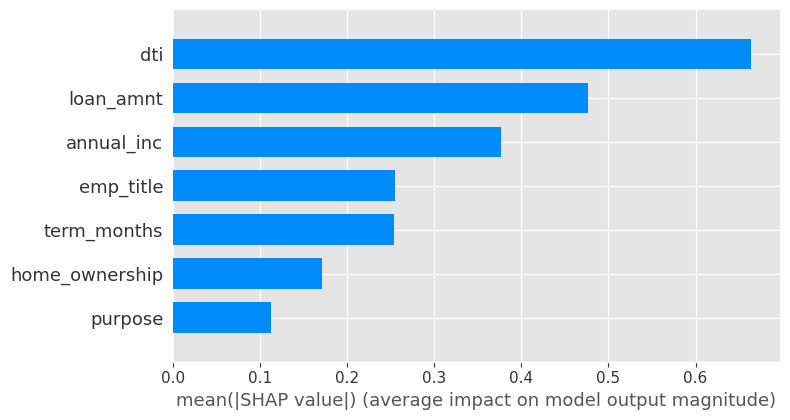

In [86]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

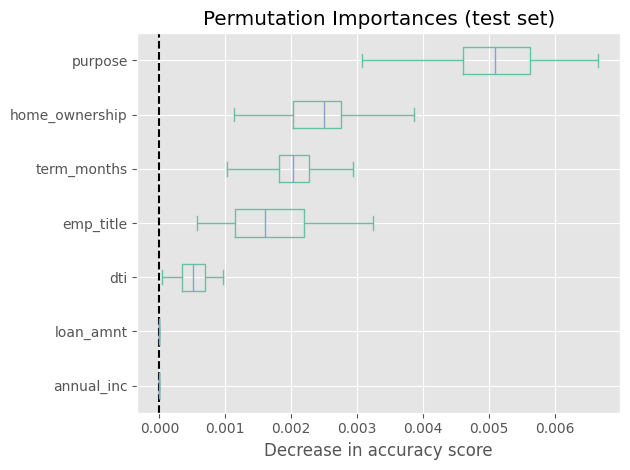

In [78]:
from sklearn.inspection import permutation_importance
result = permutation_importance(pipeline, X_test, y_test,
                           n_repeats=30,
                           random_state=0)
sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X_test.columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

In [18]:
pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('power',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('powertransformer',
                                                                   PowerTransformer())]),
                                                  ['annual_inc', 'loan_amnt',
                                                   'int_rate', 'dti'])])),
                ('catboostclassifier',
                 <catboost.core.CatBoostClassifier object at 0x34dc00770>)])